# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data

In [2]:
df1 = pd.read_csv('./../data/GPP_NEE_flux_2001-2022.csv')
df2 = pd.read_csv('./../data/voc_2010-2022.csv')
df3 = pd.read_csv('./../data/latent_heat_flux_2018-2022.csv')
df4 = pd.read_csv('./../data/latent_heat_flux_2001-2018.csv')
df5 = pd.read_csv('./../data/sensible_heat_flux_2001-2022.csv')

# Drop columnns 'Unnamed: 0'
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df3 = df3.drop(columns=['Unnamed: 0'])
df4 = df4.drop(columns=['Unnamed: 0'])
df5 = df5.drop(columns=['Unnamed: 0'])

# Convert time labels to datetime objects
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df3['Datetime'] = pd.to_datetime(df3['Datetime'])
df4['Datetime'] = pd.to_datetime(df4['Datetime'])
df5['Datetime'] = pd.to_datetime(df5['Datetime'])

# Config parameters

In [3]:
# 1) Select the aggregation method. Allowed values are 'mean' or 'median'
# agg_method = 'mean'
agg_method = 'median'
assert agg_method in ['mean', 'median']

# 2) Select the measurement hours to consider. Allowed values are 'all', 'noon'
# daily_hours = 'all'
daily_hours = 'noon'
assert daily_hours in ['all', 'noon']

In [4]:
if daily_hours=='noon':   
    # keep only observations occurring during 10.00-14.00 each day
    df1 = df1[(df1['Datetime'].dt.hour>=10) & (df1['Datetime'].dt.hour<=14)]
    df2 = df2[(df2['Datetime'].dt.hour>=10) & (df2['Datetime'].dt.hour<=14)]
    df3 = df3[(df3['Datetime'].dt.hour>=10) & (df3['Datetime'].dt.hour<=14)]
    df4 = df4[(df4['Datetime'].dt.hour>=10) & (df4['Datetime'].dt.hour<=14)]
    df5 = df5[(df5['Datetime'].dt.hour>=10) & (df5['Datetime'].dt.hour<=14)]

In [5]:
# Keep only the rows where NEE_gapfilling_method is 0
df1 = df1[df1.NEE_gapfilling_method == 0]

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [6]:
# Aggregate to daily level
if agg_method == 'mean':
    daily_df1 = df1.resample('D', on = 'Datetime').mean().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').mean().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').mean().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').mean().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').mean().reset_index()
elif agg_method == 'median':
    daily_df1 = df1.resample('D', on = 'Datetime').median().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').median().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').median().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').median().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').median().reset_index()
else:
    raise ValueError('agg_method must be either "mean" or "median"')

# Create dataframe

In [7]:
ddf1 = daily_df1[daily_df1['Datetime'].dt.year >= 2010]
ddf1.head()

ddf2 = daily_df2[daily_df2['Datetime'].dt.year >= 2010]
ddf2.head()

ddf3 = daily_df3[daily_df3['Datetime'].dt.year >= 2010]
ddf3.head()

ddf4 = daily_df4[daily_df4['Datetime'].dt.year >= 2010]
ddf4.head()

ddf4 = ddf4.rename(columns={'HYY_EDDY233.LE': 'lh_flux'})
ddf4 = ddf4.drop(columns=['HYY_EDDY233.Qc_LE'])

ddf3 = ddf3.rename(columns={'latent_heat_flux_after_4-2018': 'lh_flux'})
ddf3 = ddf3.drop(columns=['latent_heat_flux_quality_flag_after_4-2018'])
lh_df = pd.concat([ddf4, ddf3], ignore_index=True)

lh_df = lh_df[lh_df['Datetime'].dt.year >= 2010]
lh_df.head()

daily_df5.head()
#drop rows where datetime is before 2010-05-29
ddf5 = daily_df5[daily_df5['Datetime'].dt.year >= 2010]
ddf5.head()

#full_df = pd.concat([ddf1['Datetime'], ddf1['NEE']])
#full_df.head()
ddf1 = ddf1.drop(columns=['NEE_gapfilling_method', 'GPP'])
ddf5 = ddf5.drop(columns=['sensible_heat_flux_gapfilling_method'])

ddf = pd.merge(ddf1, ddf2, on='Datetime', how='inner')
ddf = pd.merge(ddf, lh_df, on='Datetime', how='inner')
ddf = pd.merge(ddf, ddf5, on='Datetime', how='inner')
ddf.head()


,Datetime,NEE,monoterpene_flux,methanol_flux,acetone_flux,acetaldehyde_flux,lh_flux,sensible_heat_flux
0,2010-05-29,-10.0310,10.613590,16.89274,7.57044,2.652575,54.65915,42.8565
1,2010-05-30,-11.4725,38.513825,34.04258,1.72830,3.922185,165.80755,174.5570
2,2010-05-31,-10.5330,54.609810,29.41079,5.05139,2.909770,194.49385,257.2225
3,2010-06-01,-9.4610,44.327820,44.19043,17.50203,NaN,170.20680,316.2715
4,2010-06-02,-8.9000,NaN,NaN,NaN,NaN,177.06070,365.3675


In [8]:
# set the window size
WINDOW_SIZE = 3

# Dictionary to help selecting data and labeling the plots
months = {1: 'January', 
          2: 'February', 
          3: 'March', 
          4: 'April', 
          5: 'May', 
          6: 'June', 
          7: 'July', 
          8: 'August', 
          9: 'September', 
          10: 'October', 
          11: 'November', 
          12: 'December'}

# select the months of interest
start_month = 1
end_month = 12

In [9]:
#metric = 'median'
metric = 'mean'

# Filter data for start_month and end_month
daily_df_med = ddf[(ddf['Datetime'].dt.month >= start_month) 
                            & (ddf['Datetime'].dt.month <= end_month)].copy()

if metric == 'median':
    daily_df_med['monoterp_rm'] = daily_df_med['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    # daily_df_med['methanol_rm'] = daily_df_med['methanol_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    # daily_df_med['acetone_rm'] = daily_df_med['acetone_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    # daily_df_med['acetaldehyde_rm'] = daily_df_med['acetaldehyde_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    daily_df_med['sensible_heat_rm'] = daily_df_med['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    daily_df_med['latent_heat_rm'] = daily_df_med['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
    daily_df_med['nee_rm'] = daily_df_med['NEE'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).median()
elif metric == 'mean':
    daily_df_med['monoterp_rm'] = daily_df_med['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    # daily_df_med['methanol_rm'] = daily_df_med['methanol_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    # daily_df_med['acetone_rm'] = daily_df_med['acetone_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    # daily_df_med['acetaldehyde_rm'] = daily_df_med['acetaldehyde_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    daily_df_med['sensible_heat_rm'] = daily_df_med['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    daily_df_med['latent_heat_rm'] = daily_df_med['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
    daily_df_med['nee_rm'] = daily_df_med['NEE'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()

# Add a column for the day of year
daily_df_med['day'] = daily_df_med['Datetime'].dt.dayofyear

# Add a column for the year
daily_df_med['year'] = daily_df_med['Datetime'].dt.year

# Pivot the DataFrame so that rows are days and columns are years
df_mono = daily_df_med.pivot(index='day', columns='year', values='monoterp_rm')
df_sensible = daily_df_med.pivot(index='day', columns='year', values='sensible_heat_rm')
df_latent = daily_df_med.pivot(index='day', columns='year', values='latent_heat_rm')
df_nee = daily_df_med.pivot(index='day', columns='year', values='nee_rm')

daily_df_med.drop(columns=['NEE', 'monoterpene_flux', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux', 'sensible_heat_flux', 'lh_flux'], inplace=True)

# create dataframe with day of year as column and 0.1 and 0.9 quantiles as rows
mono_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_mono.index) + 1))
sensible_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_sensible.index) + 1))
latent_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_latent.index) + 1))
nee_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_nee.index) + 1))

def create_arrays(row_index, dataframe):
    current_row = dataframe.iloc[row_index].to_numpy()
    
    start_index = max(1, row_index - 7)
    end_index = min(row_index + 6, len(dataframe)-1)
    
    previous_rows = dataframe.iloc[start_index:row_index].to_numpy()
    next_rows = dataframe.iloc[row_index + 1:end_index + 1].to_numpy()
    
    # Concatenate arrays
    result_array = np.concatenate([previous_rows.flatten(), current_row, next_rows.flatten()])
    
    return result_array

# quantiles for each variable calculated from same day each year +- one week

for index, row in df_mono.iterrows():
    if index == len(df_mono):
        break
    array = create_arrays(index, df_mono)
    lquant = np.nanquantile(array, 0.1)
    mono_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    mono_quant.at[0.9, index] = uquant

for index, row in df_sensible.iterrows():
    if index == len(df_sensible):
        break
    array = create_arrays(index, df_sensible)
    lquant = np.nanquantile(array, 0.1)
    sensible_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    sensible_quant.at[0.9, index] = uquant

for index, row in df_latent.iterrows():
    if index == len(df_latent):
        break
    array = create_arrays(index, df_latent)
    lquant = np.nanquantile(array, 0.1)
    latent_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    latent_quant.at[0.9, index] = uquant

for index, row in df_nee.iterrows():
    if index == len(df_nee):
        break
    array = create_arrays(index, df_nee)
    lquant = np.nanquantile(array, 0.1)
    nee_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    nee_quant.at[0.9, index] = uquant


# quantiles for each variable calculated from same day each year
    
# mono_quant = df_mono.quantile([0.1, 0.9], axis=1, numeric_only=True)
# sensible_quant = df_sensible.quantile([0.1, 0.9], axis=1, numeric_only=True)
# latent_quant = df_latent.quantile([0.1, 0.9], axis=1, numeric_only=True)
# nee_quant = df_nee.quantile([0.1, 0.9], axis=1, numeric_only=True)

daily_df_med.set_index('Datetime', inplace=True)

# calculate outliers
for index, row in daily_df_med.iterrows():
    day = index.dayofyear
    if row['monoterp_rm'] < mono_quant[day][0.1] or row['monoterp_rm'] > mono_quant[day][0.9]:
        daily_df_med.at[index, 'monoterp_outlier'] = 1
    else:
        daily_df_med.at[index, 'monoterp_outlier'] = 0

    if row['sensible_heat_rm'] < sensible_quant[day][0.1] or row['sensible_heat_rm'] > sensible_quant[day][0.9]:
        daily_df_med.at[index, 'sensible_heat_outlier'] = 1
    else:
        daily_df_med.at[index, 'sensible_heat_outlier'] = 0

    if row['latent_heat_rm'] < latent_quant[day][0.1] or row['latent_heat_rm'] > latent_quant[day][0.9]:
        daily_df_med.at[index, 'latent_heat_outlier'] = 1
    else:
        daily_df_med.at[index, 'latent_heat_outlier'] = 0

    if row['nee_rm'] < nee_quant[day][0.1] or row['nee_rm'] > nee_quant[day][0.9]:
        daily_df_med.at[index, 'nee_outlier'] = 1
    else:
        daily_df_med.at[index, 'nee_outlier'] = 0

daily_df_med.drop(columns=['monoterp_rm', 'sensible_heat_rm', 'latent_heat_rm', 'nee_rm', 'year'], inplace=True)

daily_df_med_2010 = daily_df_med[daily_df_med.index.year == 2010]
daily_df_med_2011 = daily_df_med[daily_df_med.index.year == 2011]
daily_df_med_2012 = daily_df_med[daily_df_med.index.year == 2012]
daily_df_med_2013 = daily_df_med[daily_df_med.index.year == 2013]
daily_df_med_2014 = daily_df_med[daily_df_med.index.year == 2014]
daily_df_med_2015 = daily_df_med[daily_df_med.index.year == 2015]
daily_df_med_2016 = daily_df_med[daily_df_med.index.year == 2016]
daily_df_med_2017 = daily_df_med[daily_df_med.index.year == 2017]
daily_df_med_2018 = daily_df_med[daily_df_med.index.year == 2018]
daily_df_med_2019 = daily_df_med[daily_df_med.index.year == 2019]
daily_df_med_2020 = daily_df_med[daily_df_med.index.year == 2020]
daily_df_med_2021 = daily_df_med[daily_df_med.index.year == 2021]
daily_df_med_2022 = daily_df_med[daily_df_med.index.year == 2022]

daily_df_med_2010.set_index('day', inplace=True)
daily_df_med_2011.set_index('day', inplace=True)
daily_df_med_2012.set_index('day', inplace=True)
daily_df_med_2013.set_index('day', inplace=True)
daily_df_med_2014.set_index('day', inplace=True)
daily_df_med_2015.set_index('day', inplace=True)
daily_df_med_2016.set_index('day', inplace=True)
daily_df_med_2017.set_index('day', inplace=True)
daily_df_med_2018.set_index('day', inplace=True)
daily_df_med_2019.set_index('day', inplace=True)
daily_df_med_2020.set_index('day', inplace=True)
daily_df_med_2021.set_index('day', inplace=True)
daily_df_med_2022.set_index('day', inplace=True)



/tmp/ipykernel_64911/3665788502.py:17: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  daily_df_med['monoterp_rm'] = daily_df_med['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
/tmp/ipykernel_64911/3665788502.py:21: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  daily_df_med['sensible_heat_rm'] = daily_df_med['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
/tmp/ipykernel_64911/3665788502.py:22: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  daily_df_med['latent_heat_rm'] = daily_df_med['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1, axis=0, center=True).mean()
/tm

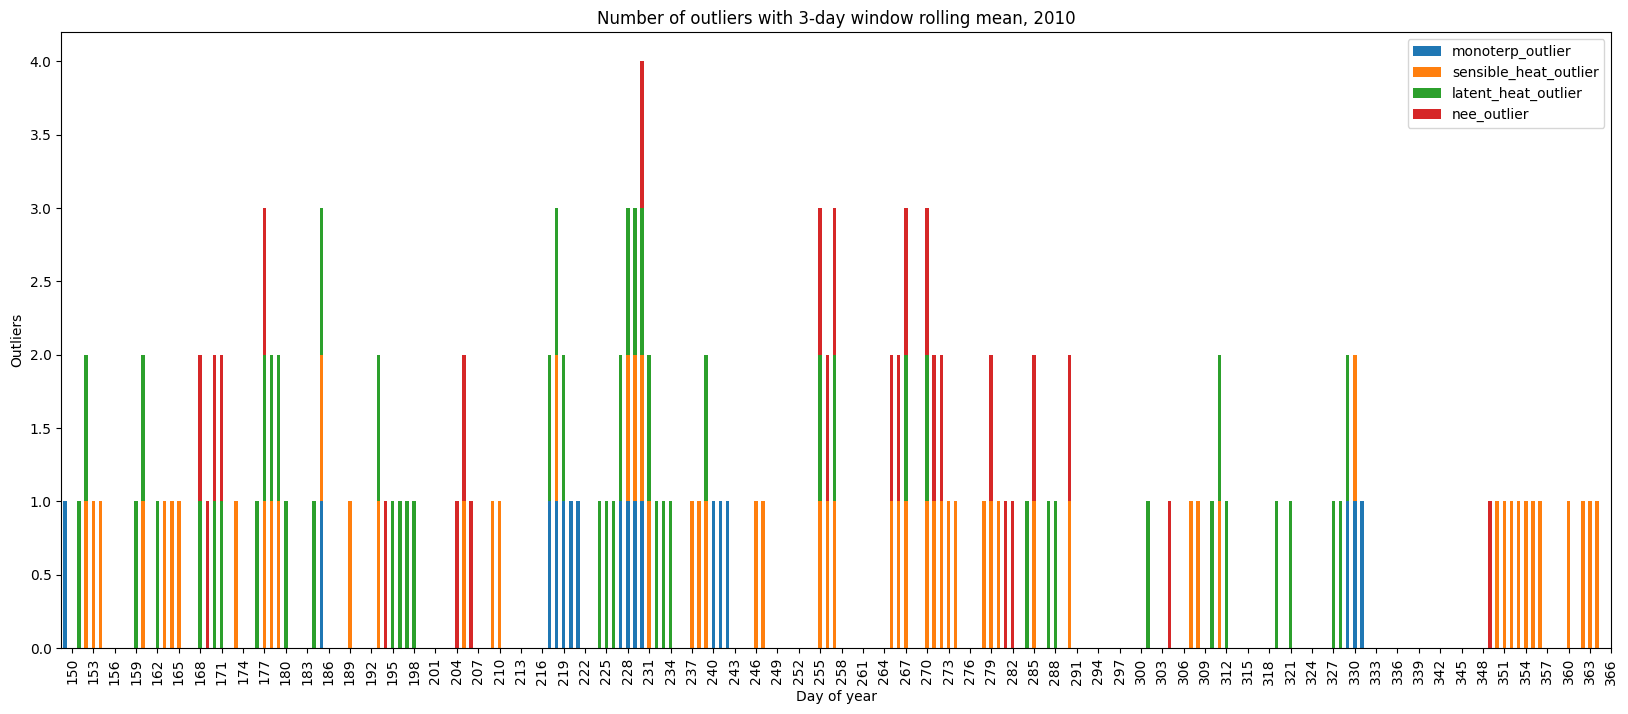

In [10]:
daily_df_med_2010.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2010.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2010.index + 1)[np.array(ticks)-1])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2010')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


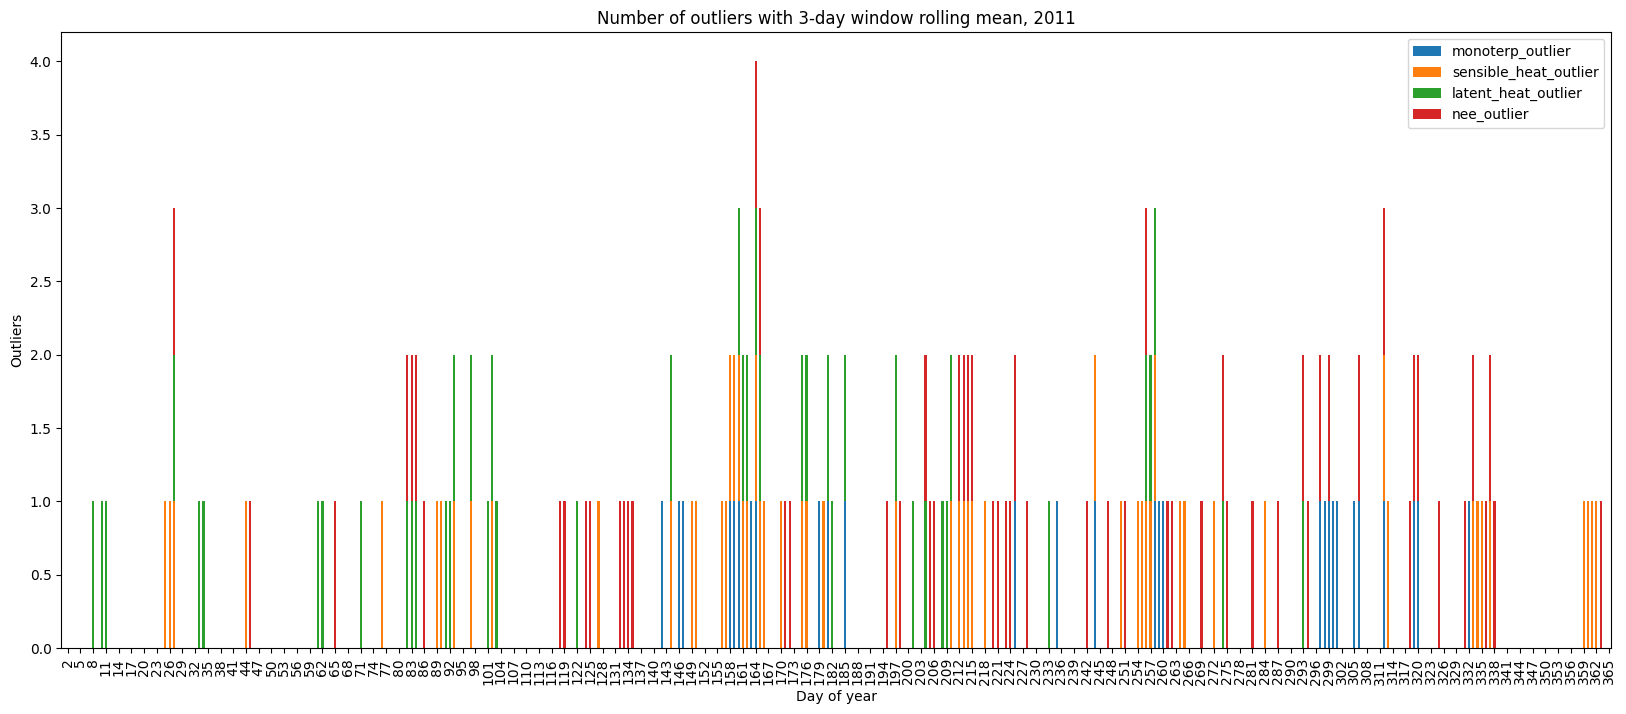

In [11]:
daily_df_med_2011.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2011.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2011.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2011')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()

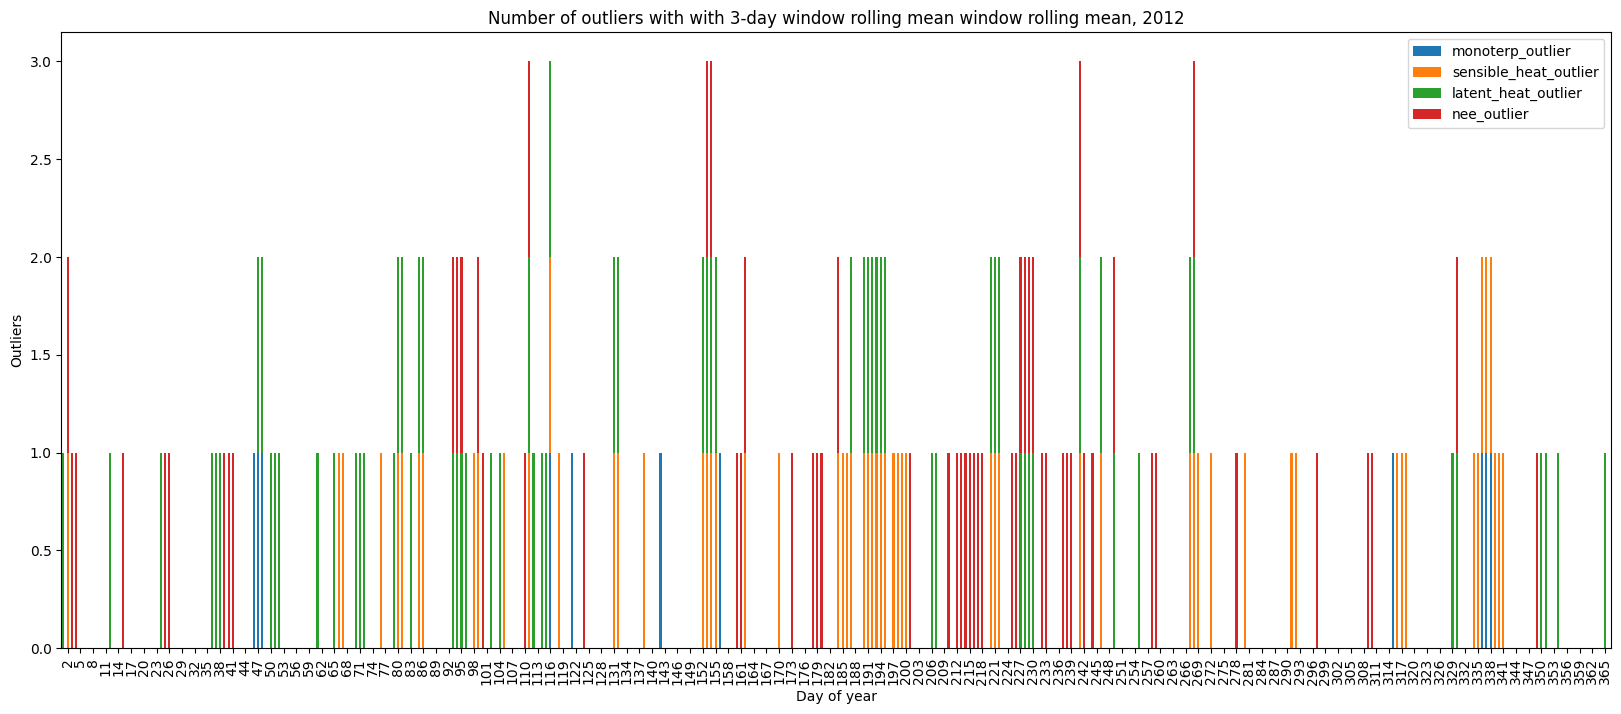

In [12]:
daily_df_med_2012.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2012.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2012.index)[np.array(ticks)])
plt.title(f'Number of outliers with with {WINDOW_SIZE}-day window rolling {metric} window rolling {metric}, 2012')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()



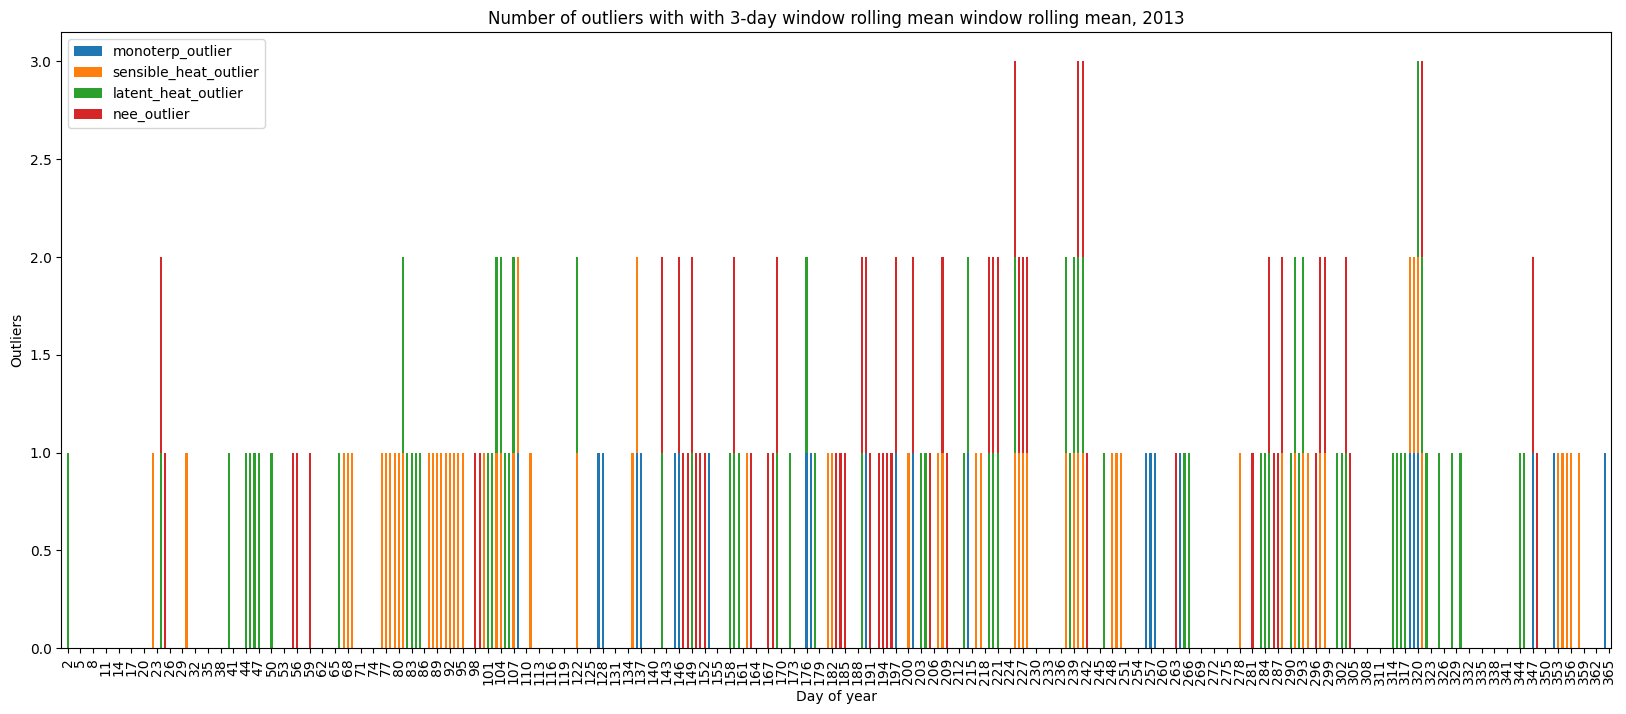

In [13]:
daily_df_med_2013.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2013.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2013.index)[np.array(ticks)])
plt.title(f'Number of outliers with with {WINDOW_SIZE}-day window rolling {metric} window rolling {metric}, 2013')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


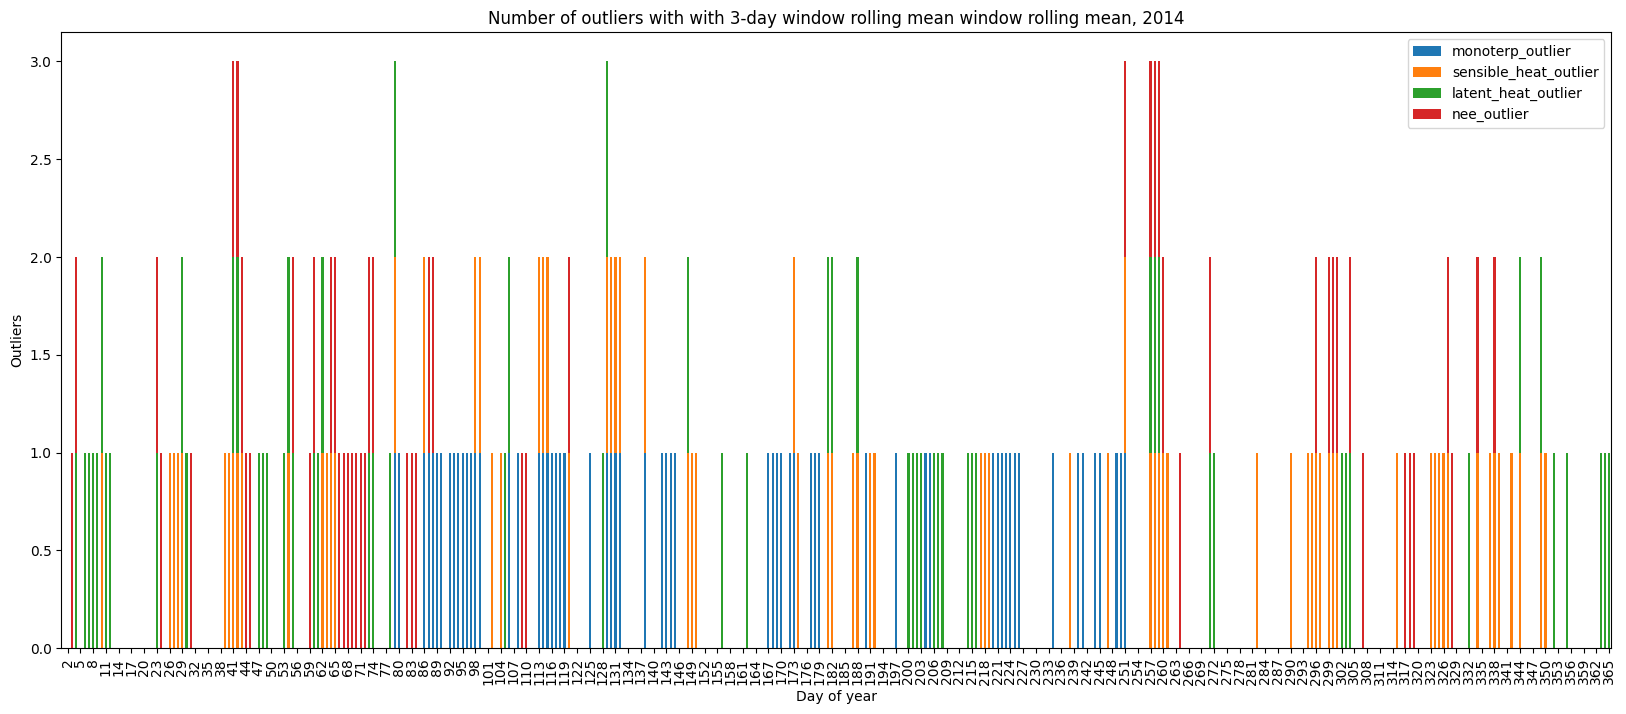

In [14]:
daily_df_med_2014.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2014.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2014.index)[np.array(ticks)])
plt.title(f'Number of outliers with with {WINDOW_SIZE}-day window rolling {metric} window rolling {metric}, 2014')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


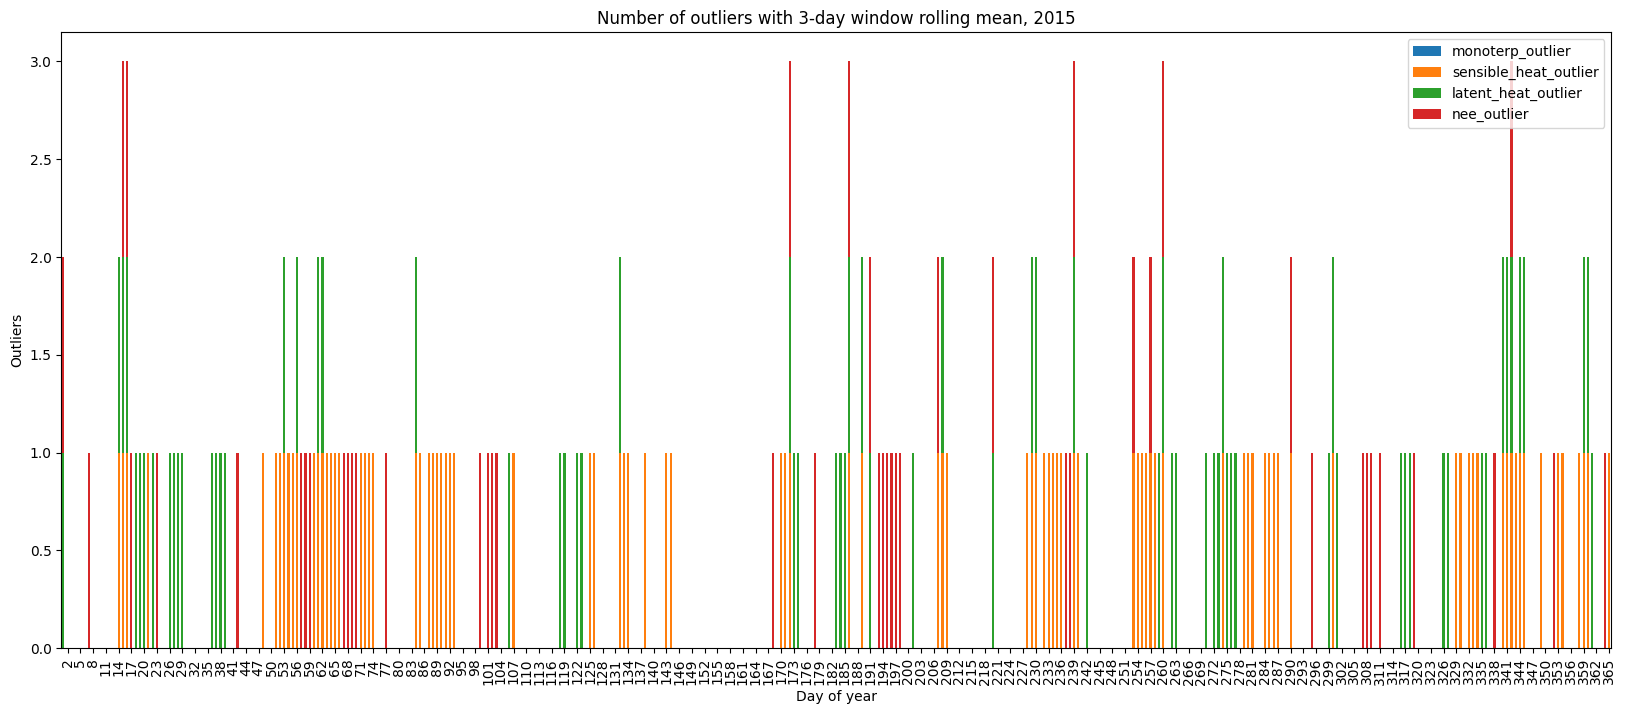

In [15]:
daily_df_med_2015.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2015.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2015.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2015')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


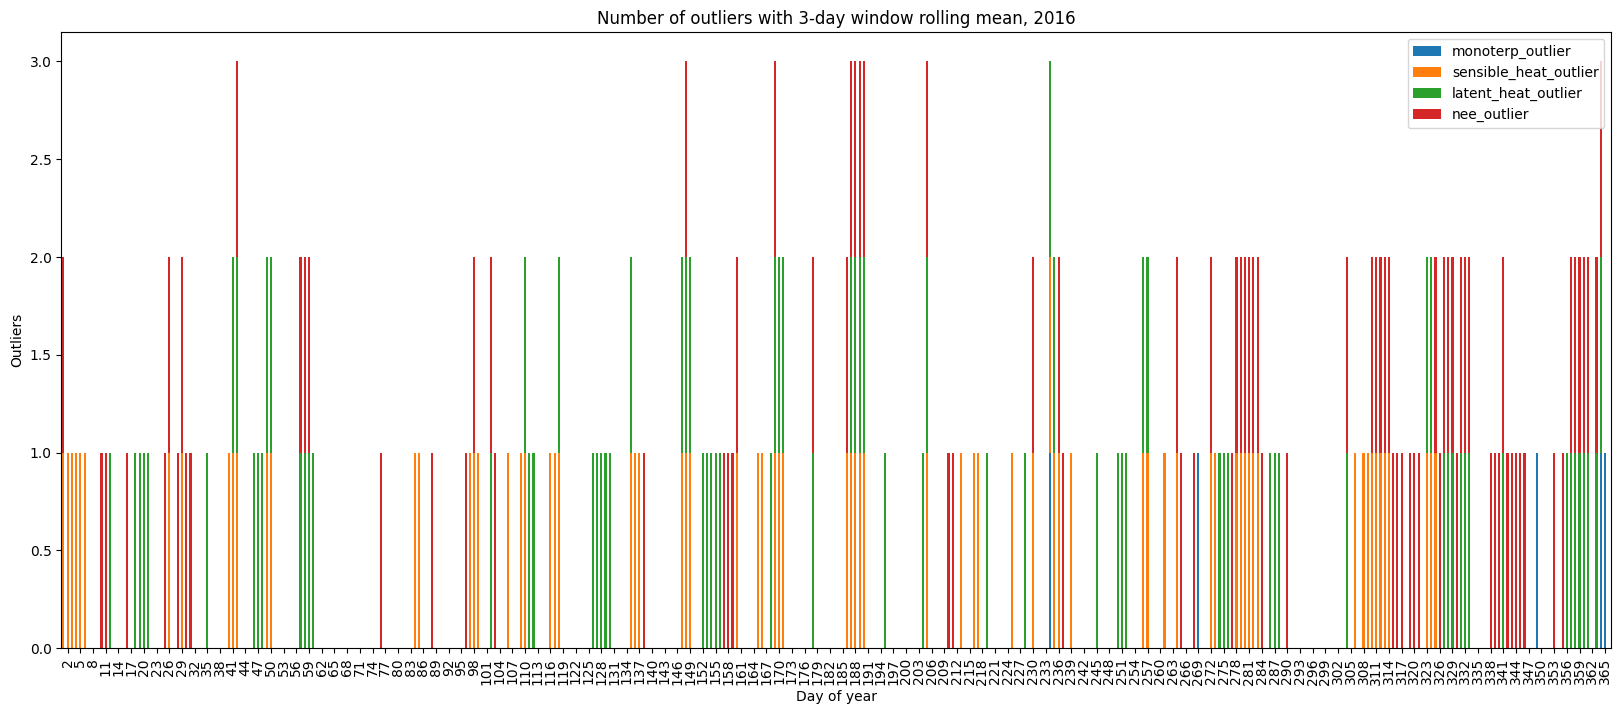

In [16]:
daily_df_med_2016.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2016.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2016.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2016')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


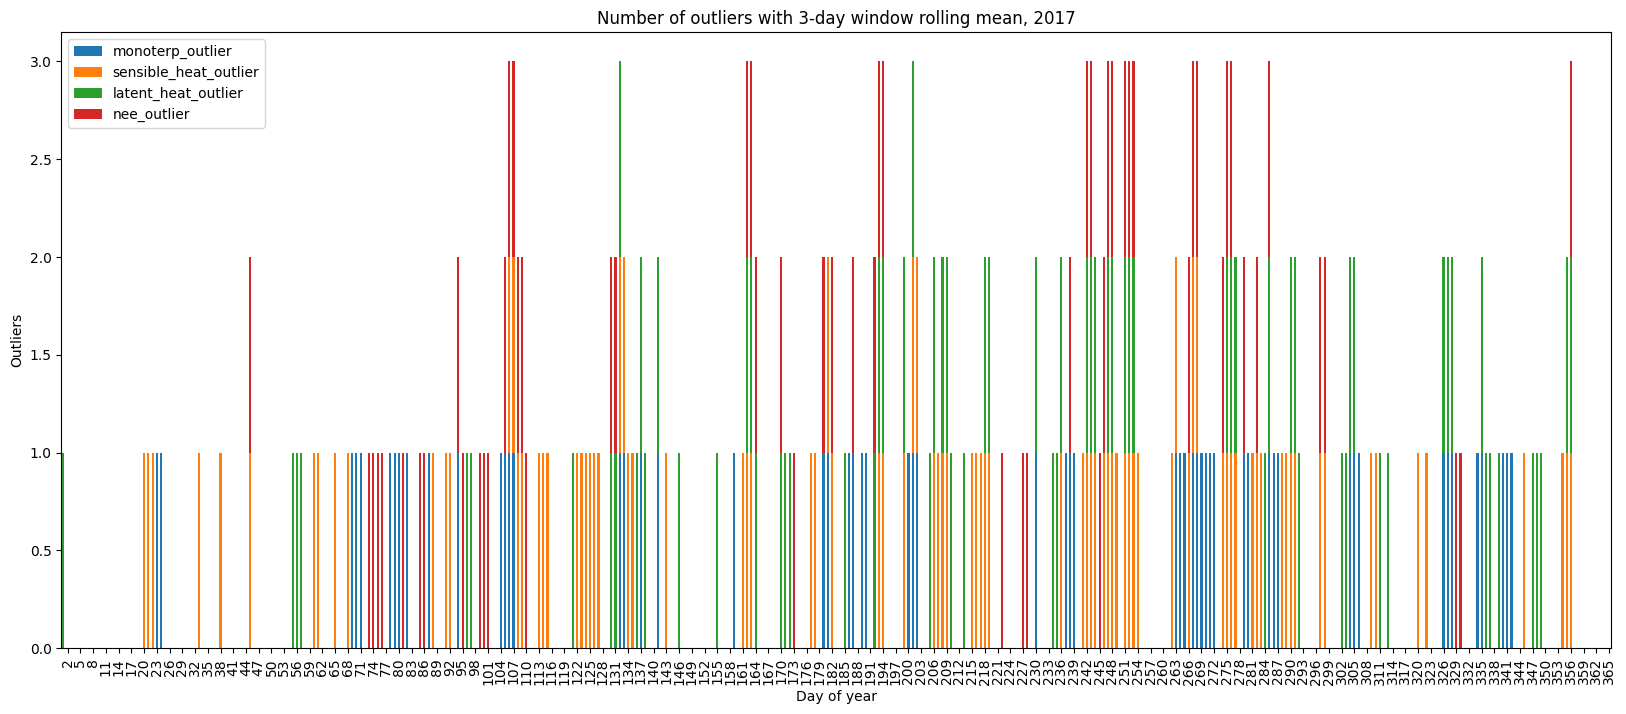

In [17]:
daily_df_med_2017.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2017.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2017.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2017')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()

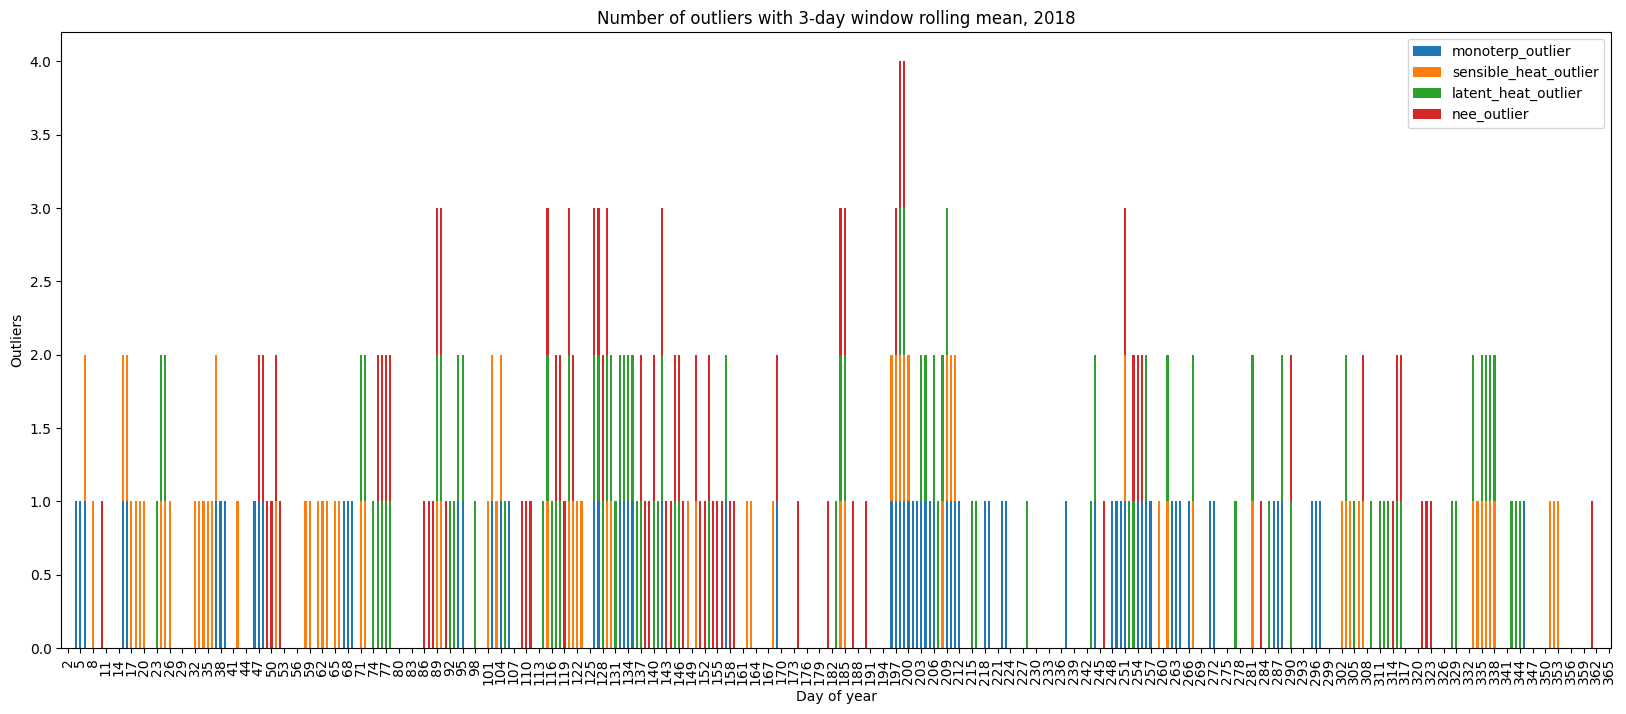

In [18]:
daily_df_med_2018.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2018.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2018.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2018')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()



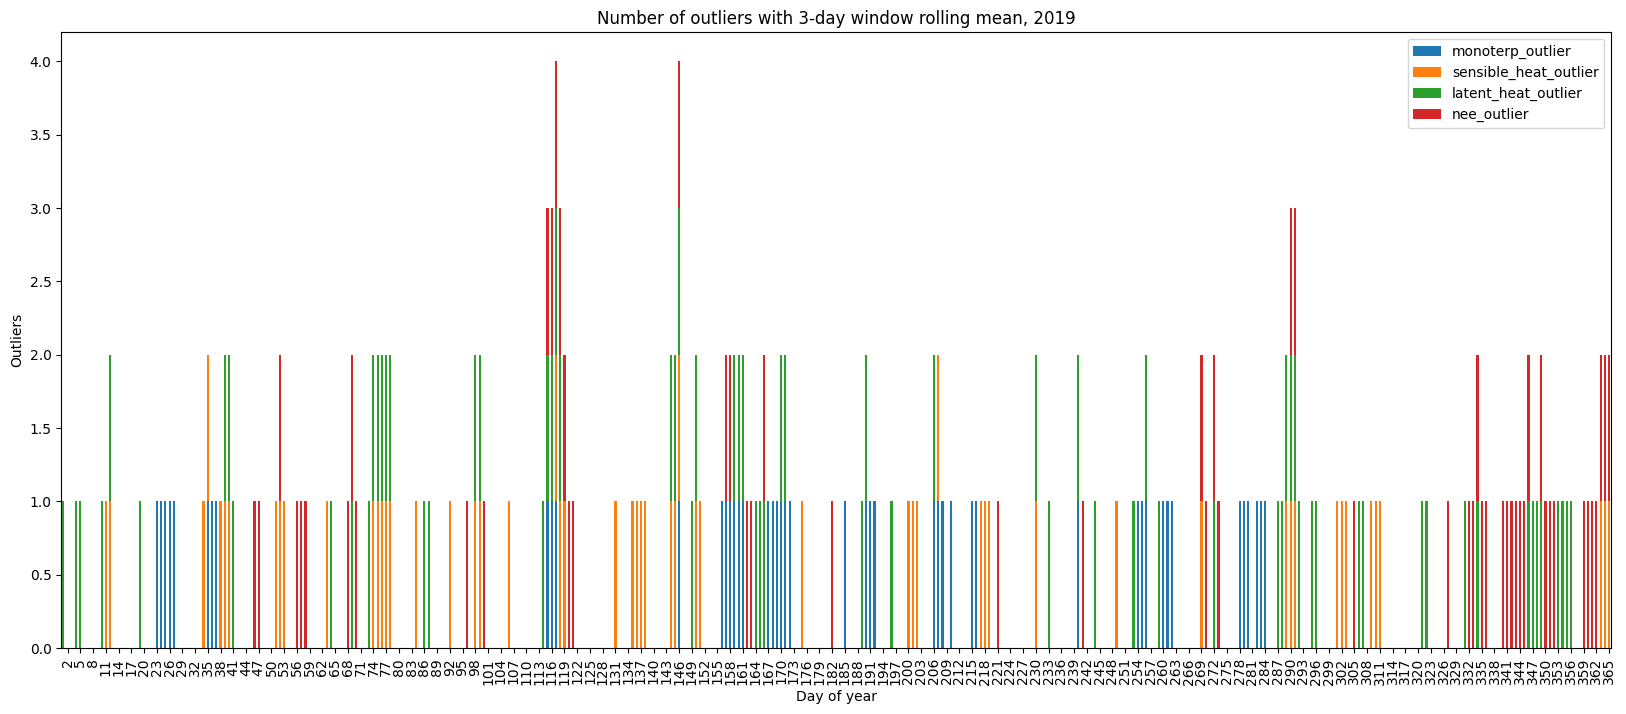

In [19]:
daily_df_med_2019.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2019.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2019.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2019')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()


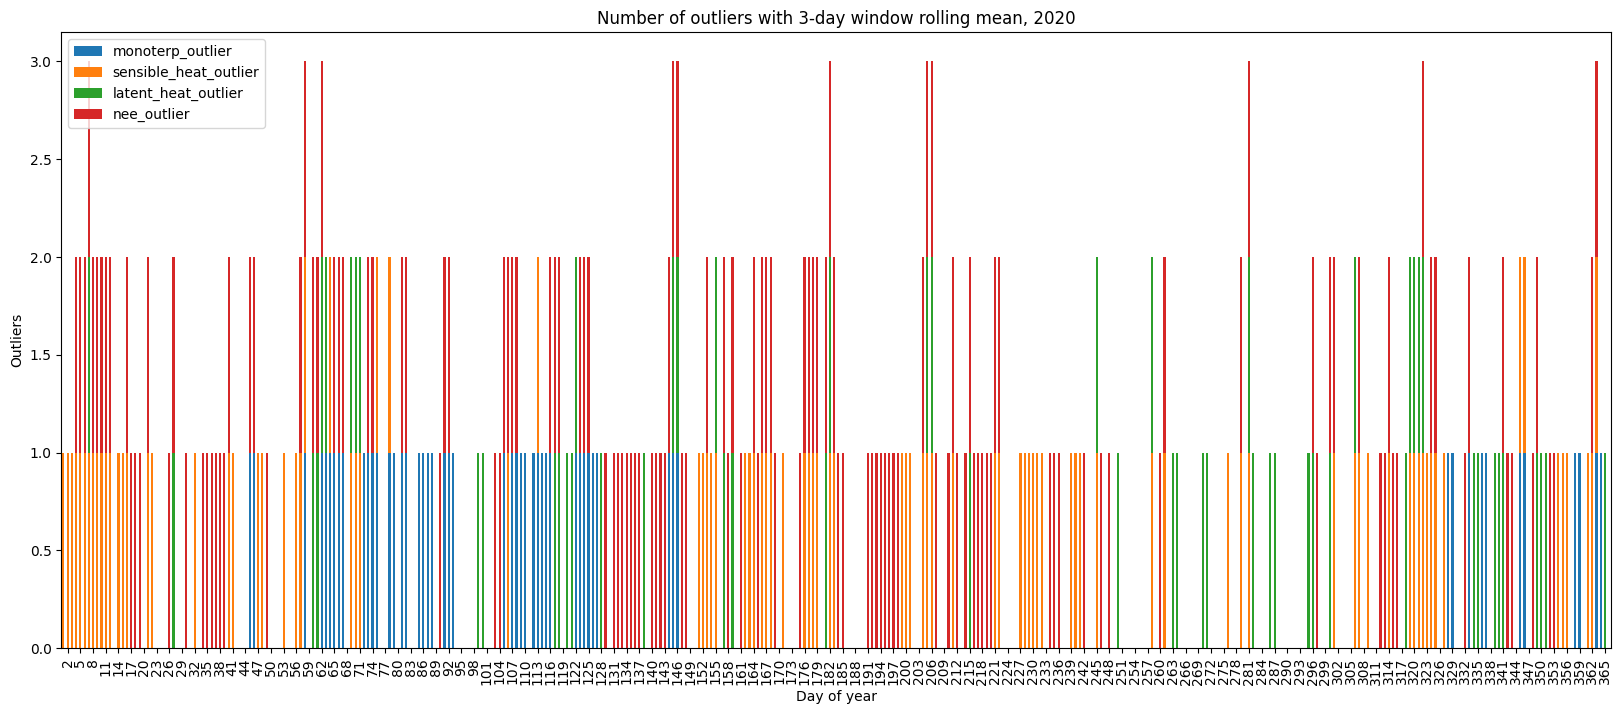

In [20]:
daily_df_med_2020.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2020.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2020.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2020')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()



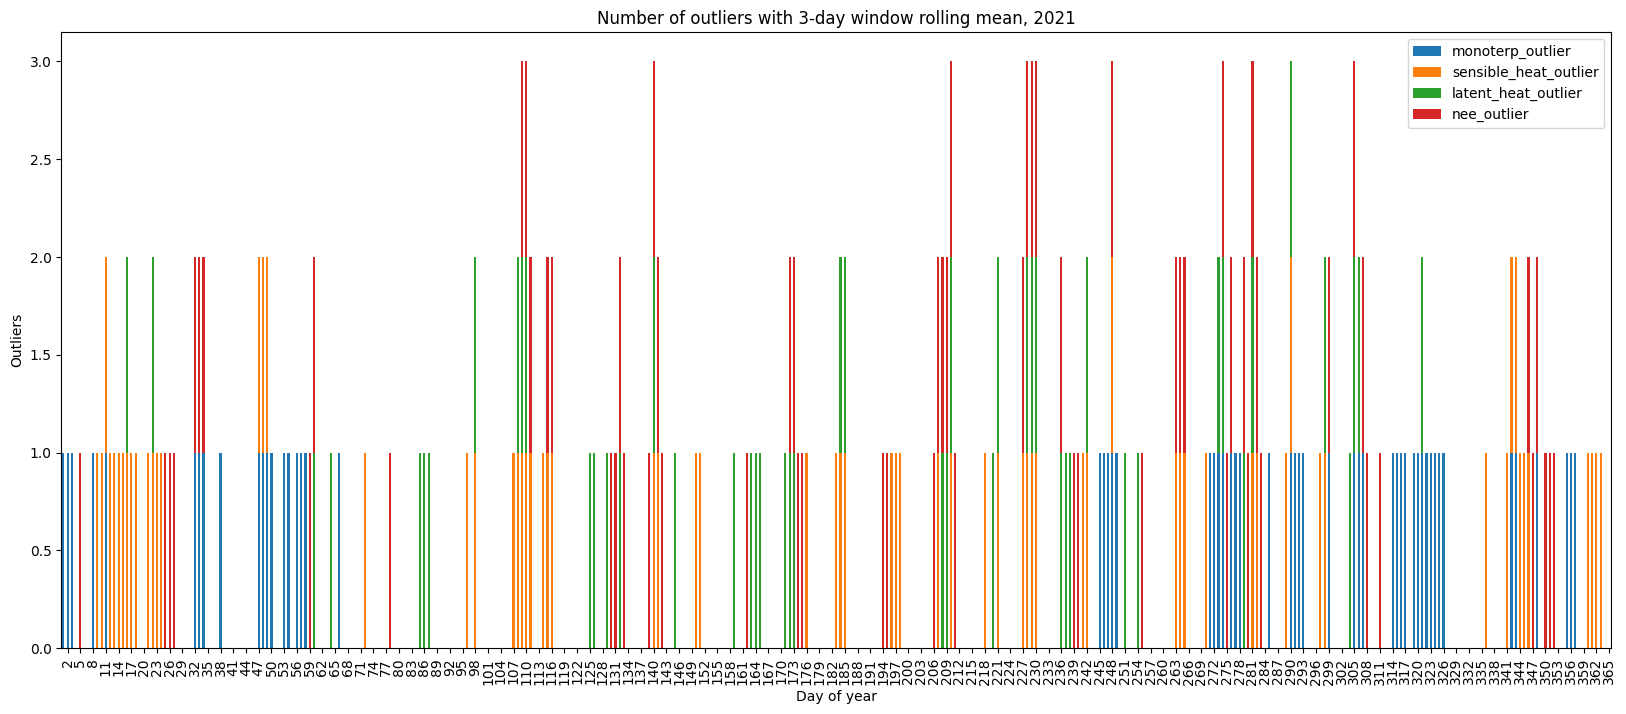

In [21]:
daily_df_med_2021.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2021.index)+1, 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2021.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2021')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()



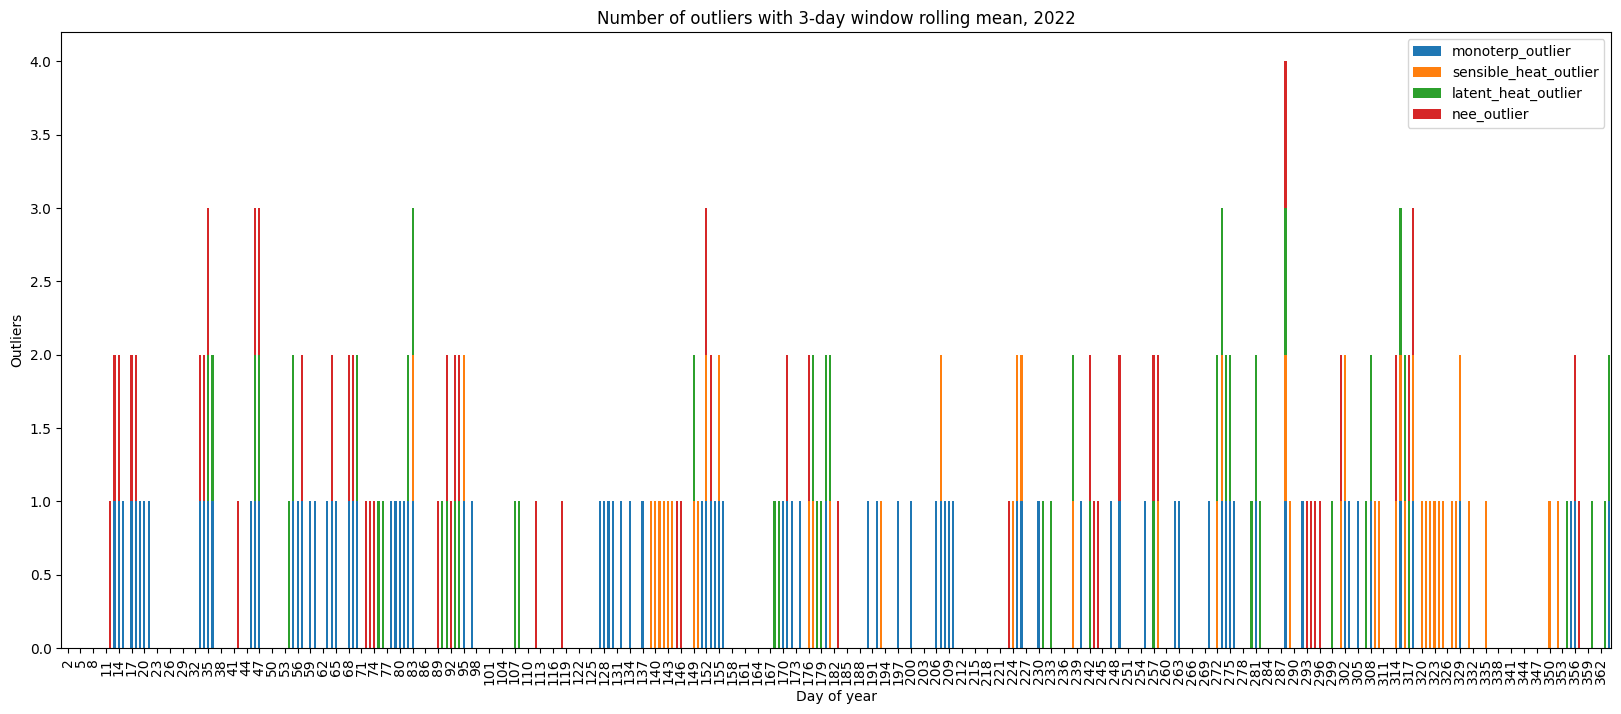

In [22]:
daily_df_med_2022.plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(daily_df_med_2022.index), 3))

plt.xticks(ticks, labels=np.array(daily_df_med_2022.index)[np.array(ticks)])
plt.title(f'Number of outliers with {WINDOW_SIZE}-day window rolling {metric}, 2022')
plt.xlabel('Day of year')
plt.ylabel('Outliers')
plt.show()
